In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

import pandas as pd
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Build unit response to AEP matrix 

In [4]:
def build_AEP_unit_AM(session, area, AEP_target, ev_type=1):
    session_data = load_session_data(session)
    spike_times  = session_data['spike_times']
    unit_names   = session_data['unit_names']
    aeps_events  = session_data['aeps_events']
    AEP_metrics_lims = session_data['AEP_metrics_lims']
    AEP_metrics_raw  = session_data['AEP_metrics_raw']
    AEP_metrics_norm = session_data['AEP_metrics_norm']

    if area == 'A1':
        sel_units = [unit for unit in unit_names if int(unit[0]) < 3]
    else:
        sel_units = unit_names  # all units

    # background only
    aeps_bgr_idxs   = np.where(aeps_events[:, 1] == ev_type)[0]
    aeps_bgr_events = aeps_events[aeps_bgr_idxs]

    win_l = AEP_metrics_lims[area][AEP_target][0] / 1000  # ms to s
    win_r = AEP_metrics_lims[area][AEP_target][1] / 1000  # ms to s
    unit_act_matrix = np.zeros([len(aeps_bgr_events), len(sel_units)])
    for i, aep_event in enumerate(aeps_bgr_events):
        t_l = aep_event[0] + win_l
        t_r = aep_event[0] + win_r #+ 0.05

        for j, unit_name in enumerate(sel_units):
            spks = spike_times[unit_name]
            unit_act_matrix[i, j] = len(spks[(spks > t_l) & (spks < t_r)])

    AEP_tgt_responses = AEP_metrics_norm[area][AEP_target][aeps_bgr_idxs]
    
    return unit_act_matrix, AEP_tgt_responses

## GLM fit and prediction

In [5]:
def get_GLM_and_prediction(unit_AM, AEP_responses, test_size=0.33, bin_width=10, glm_min_pval=0.95):
    """
    unit_AM       - unit activity matrix (spikes counts to certain part of AEP responses)
    AEP_responses - target AEP component values to unit_AM
    test_size     - how much to split train / test
    bin_width     - number of AEPs to sum spikes
    glm_min_pval  - criteria (GLM fit p-val) to include units for prediction
    """

    # separate train / test
    X_train, X_test, y_train, y_test = train_test_split(unit_AM, AEP_responses, test_size=test_size)
    
    # divide train in groups by AEP_target value to get more spikes from each unit -> grouped AM
    bin_count = int(np.ceil(len(y_train)/bin_width))
    bins = np.linspace(0, bin_width * bin_count, bin_count + 1, dtype=np.int16)
    sort_idxs = np.argsort(y_train)

    # build sorted train datasets
    X_sorted = X_train[sort_idxs]
    y_sorted = y_train[sort_idxs]

    # compute averaged activity matrix
    X_grouped = np.zeros([len(bins) - 1, unit_AM.shape[1]])
    y_grouped = np.zeros(len(bins) - 1)
    for i in range(len(bins) - 1):
        # FIXME!! HERE SHOULD BE PCA first PC and not just a sum!!!???
        X_grouped[i] = X_sorted[bins[i]:bins[i + 1]].sum(axis=0) / bin_width
        y_grouped[i] = y_sorted[bins[i]:bins[i + 1]].mean()
        
    # z-score - doesnt really change much
    #X_grouped = stats.zscore(X_grouped, axis=0)
    
    # train glm to get contributions of each unit
    data = np.column_stack([y_grouped, X_grouped])
    columns = ['state'] + ["x%d" % x for x in range(X_grouped.shape[1])]
    AM_df = pd.DataFrame(data, columns=columns)

    model = glm('state ~ ' + ' + '.join(columns[1:]), data=AM_df).fit()
    #model.summary()
    
    # 
    glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < glm_min_pval])
    #if len(glm_coeffs) == 0:
    #    return 0, 0, model.params, model.pvalues
    AEP_target_fit = np.zeros(len(y_test))
    for idx, coef in glm_coeffs.items():
        AEP_target_fit += coef * X_test[:, idx]

    corr, pval = stats.pearsonr(AEP_target_fit, y_test)
    
    return corr, pval, model.params, model.pvalues

## Compute original, shuffled and random splits

In [9]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [21]:
selected = sessions[6:]
selected

['009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [22]:
AEP_targets = ['P1', 'N1', 'P2', 'P3']
area = 'A1'
iter_count = 1000

for session in selected:
    animal = session.split('_')[0]
    aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')

    collected = {}
    for AEP_target in AEP_targets:
        unit_AM, AEP_responses = build_AEP_unit_AM(session, area, AEP_target)

        # compute original
        corr, pval, params, pvalues = get_GLM_and_prediction(unit_AM, AEP_responses)

        # compute shuffled
        corr_mx_shuf = np.zeros([iter_count, 2])  # coeff, pval for each shuffle
        for i in range(iter_count):
            unit_AM_s = unit_AM.copy()
            np.random.shuffle(unit_AM_s)
            corr_s, pval_s, _, _ = get_GLM_and_prediction(unit_AM_s, AEP_responses)
            corr_mx_shuf[i] = (corr_s, pval_s)
            del unit_AM_s

        # compute chunked or just diff train / split?
        corr_mx_chun = np.zeros([iter_count, 2])
        for i in range(iter_count):
            corr_s, pval_s, _, _ = get_GLM_and_prediction(unit_AM, AEP_responses)  # just diff train / split
            corr_mx_chun[i] = (corr_s, pval_s)

        with h5py.File(aeps_pop_file, 'a') as f:
            if not AEP_target in f:
                f.create_group(AEP_target)
            tgt_grp = f[AEP_target]

            for val in ['corr_glm_fit_orig', 'glm_fit_params', 'glm_fit_pvalues', 'corr_glm_fit_shuf', 'corr_glm_fit_chun']:
                if val in tgt_grp:
                    del tgt_grp[val]

            tgt_grp.create_dataset('corr_glm_fit_orig', data=np.array([corr, pval]))
            tgt_grp.create_dataset('glm_fit_params', data=params)
            tgt_grp.create_dataset('glm_fit_pvalues', data=pvalues)
            tgt_grp.create_dataset('corr_glm_fit_shuf', data=corr_mx_shuf)
            tgt_grp.create_dataset('corr_glm_fit_chun', data=corr_mx_chun)

        print("%s done" % AEP_target)
    print("%s done" % session)

P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-02-28_20-45-04 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-01_10-46-12 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-02_09-32-54 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-02_16-27-42 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-02_20-11-35 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-03_09-37-07 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-03_16-00-47 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-04_11-12-04 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-05_11-52-17 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-05_18-31-32 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-08_18-10-07 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-09_20-03-08 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_2023-03-10_09-57-34 done
P1 done
N1 done
P2 done
P3 done
009265_hippoSIT_202

## Train on BGR (66%), predict on BGR (33%)

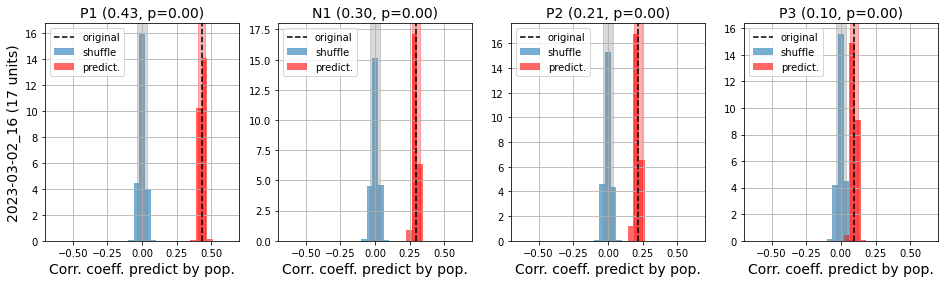

In [25]:
session = selected[3]
animal = session.split('_')[0]
aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')

collected = {}
with h5py.File(aeps_pop_file, 'r') as f:
    for grp in f:
        collected[grp] = {}
        collected[grp]['corr_glm_fit_orig'] = np.array(f[grp]['corr_glm_fit_orig'])
        collected[grp]['glm_fit_params']    = np.array(f[grp]['glm_fit_params'])
        collected[grp]['glm_fit_pvalues']   = np.array(f[grp]['glm_fit_pvalues'])
        collected[grp]['corr_glm_fit_shuf'] = np.array(f[grp]['corr_glm_fit_shuf'])
        collected[grp]['corr_glm_fit_chun'] = np.array(f[grp]['corr_glm_fit_chun'])

bins = np.linspace(-1, 1, 50)
cols = len(collected.keys())

fig, axes = plt.subplots(1, cols, figsize=(4*cols, 4))

for i, AEP_target in enumerate(AEP_targets):
    if not AEP_target in collected:
        continue
    
    corr = collected[AEP_target]['corr_glm_fit_orig'][0]
    pval = collected[AEP_target]['corr_glm_fit_orig'][1]
    corr_mx_shuf = collected[AEP_target]['corr_glm_fit_shuf']
    corr_mx_chun = collected[AEP_target]['corr_glm_fit_chun']
    
    min_pval = 0.99  # select some or all
    coeffs_shuf = corr_mx_shuf[corr_mx_shuf[:, 1] < min_pval][:, 0]
    coeffs_chun = corr_mx_chun[corr_mx_chun[:, 1] < min_pval][:, 0]

    ax = axes[i]
    ax.hist(coeffs_shuf, bins=bins, alpha=0.6, density=True, label='shuffle', color='tab:blue')
    ax.hist(coeffs_chun, bins=bins, alpha=0.6, density=True, label='predict.', color='red')
    ax.axvspan(np.percentile(coeffs_shuf, 5), np.percentile(coeffs_shuf, 95), alpha=0.3, color='gray')
    ax.axvspan(np.percentile(coeffs_chun, 5), np.percentile(coeffs_chun, 95), alpha=0.3, color='red')
    ax.axvline(coeffs_chun.mean(), color='black', ls='--', label='original')
    ax.set_xlim(-0.7, 0.7)
    ax.grid()
    ax.legend(loc='upper left')
    ax.set_xlabel('Corr. coeff. predict by pop.', fontsize=14)
    ax.set_title('%s (%.2f, p=%.2f)' % (AEP_target, coeffs_chun.mean(), pval), fontsize=14)
    
    if i == 0:
        ax.set_ylabel('%s (%d units)' % (session[-19:-6], len(collected[grp]['glm_fit_params']) - 1), fontsize=14)
        
fig.savefig(os.path.join(report, 'pop2AEP', '%s_pop2AEP_corrs.pdf' % session[-19:-6]))

## Train on BGR (66%), predict on TGT

In [19]:
for session in selected:
    animal = session.split('_')[0]
    aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')

    collected = {}
    with h5py.File(aeps_pop_file, 'r') as f:
        for grp in f:
            collected[grp] = {}
            #collected[grp]['corr_glm_fit_orig'] = np.array(f[grp]['corr_glm_fit_orig'])
            collected[grp]['glm_fit_params']    = np.array(f[grp]['glm_fit_params'])
            collected[grp]['glm_fit_pvalues']   = np.array(f[grp]['glm_fit_pvalues'])
            collected[grp]['corr_glm_fit_shuf'] = np.array(f[grp]['corr_glm_fit_shuf'])
            #collected[grp]['corr_glm_fit_chun'] = np.array(f[grp]['corr_glm_fit_chun'])


    results = np.zeros([len(AEP_targets), 2])
    for i, AEP_target in enumerate(AEP_targets):
        # target only AM
        unit_AM, AEP_responses = build_AEP_unit_AM(session, area, AEP_target, ev_type=2)
        glm_coeffs = collected[AEP_target]['glm_fit_params'][1:]  # don't forget intercept

        AEP_target_fit = np.zeros(len(AEP_responses))
        for j, coef in enumerate(glm_coeffs):
            AEP_target_fit += coef * unit_AM[:, j]

        results[i] = stats.pearsonr(AEP_target_fit, AEP_responses)
        
    print(session)
    print(results)

009265_hippoSIT_2023-02-28_13-16-10
[[0.13893852 0.00018228]
 [0.11741286 0.00158766]
 [0.15678308 0.0000235 ]
 [0.16209042 0.00001221]]


## Cross-session stats

In [34]:
selected = sessions[5:-2]
selected

['009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34']

Text(0, 0.5, 'Corr. coeff. predict by population')

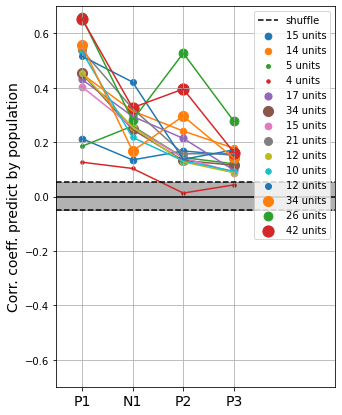

In [35]:
fig, ax = plt.subplots(1,1, figsize=(5, 7))

perc_shuf = np.zeros([len(selected), 2])  # max shuffled percentiles
for j, session in enumerate(selected):
    animal = session.split('_')[0]
    aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')
    
    corr_vals = np.zeros(len(AEP_targets))
    perc_curr = np.zeros([len(AEP_targets), 2])
    unit_no = 0
    with h5py.File(aeps_pop_file, 'r') as f:
        for i, AEP_target in enumerate(AEP_targets):
            unit_no = len(np.array(f[AEP_target]['glm_fit_pvalues'])) - 1
            corr_mx = np.array(f[AEP_target]['corr_glm_fit_chun'])
            corr_vals[i] = corr_mx[:, 0].mean()
            
            coeffs_shuf = np.array(f[AEP_target]['corr_glm_fit_shuf'])[:, 0]
            perc_curr[i] = np.array([np.percentile(coeffs_shuf, 5), np.percentile(coeffs_shuf, 95)])
    perc_shuf[j] = perc_curr.max(axis=0)
            
    x_vals = np.arange(len(corr_vals)) + 1 #+ np.random.rand(len(corr_vals)) * 0.2 - 0.1
    
    ax.scatter(x_vals, corr_vals, s=3*unit_no, label="%d units" % unit_no)
    ax.plot(x_vals, corr_vals)
    
ax.set_ylim(-0.7, 0.7)
ax.set_xlim(0.5, 6)
ax.axhline(0, color='black')
ax.grid()
ax.set_xticks(x_vals)
ax.set_xticklabels(AEP_targets, fontsize=14)
ax.axhline(perc_shuf[:, 0].min(), ls='--', color='black', label='shuffle')
ax.axhline(perc_shuf[:, 1].max(), ls='--', color='black')
ax.axhspan(perc_shuf[:, 0].min(), perc_shuf[:, 1].max(), alpha=0.3, color='black')
ax.legend(loc='upper right')
ax.set_ylabel('Corr. coeff. predict by population', fontsize=14)

## Development

### Session data

In [825]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [826]:
session = selected_009266[-5]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-05-22_09-27-22'

### GLM coeffs for each unit

In [830]:
# build activity matrix (spike counts) for each AEP in a AEP_target range
session = selected_009266[-5]
AEP_target = 'P3'
area = 'A1'

unit_act_matrix, AEP_tgt_responses = build_AEP_unit_AM(session, area, AEP_target)

Text(0.5, 0, 'AEP Metric Dynamics')

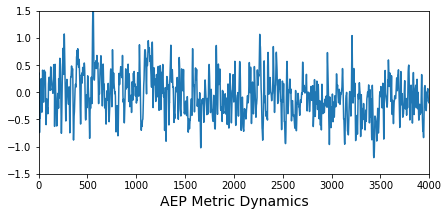

In [848]:
fig, ax = plt.subplots(1,1, figsize=(7, 3))

ax.plot(AEP_tgt_responses)
ax.set_xlim(0, 4000)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('AEP Metric Dynamics', fontsize=14)

Text(0, 0.5, 'AEP #')

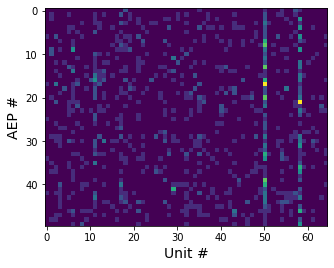

In [847]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))

ax.imshow(unit_act_matrix[:50])
ax.set_xlabel('Unit #', fontsize=14)
ax.set_ylabel('AEP #', fontsize=14)

In [835]:
# separate train / test
X_train, X_test, y_train, y_test = train_test_split(unit_act_matrix, AEP_tgt_responses, test_size=0.33)
X_train.shape, y_train.shape

((3429, 65), (3429,))

In [836]:
# divide train in groups by AEP_target value to get more spikes from each unit -> grouped AM
bin_width = 10  # number of AEPs to sum spikes

bin_count = int(np.ceil(len(y_train)/bin_width))
bins = np.linspace(0, bin_width * bin_count, bin_count + 1, dtype=np.int16)
sort_idxs = np.argsort(y_train)

# build sorted train datasets
X_sorted = X_train[sort_idxs]
y_sorted = y_train[sort_idxs]

# compute averaged activity matrix
X_grouped = np.zeros([len(bins) - 1, unit_act_matrix.shape[1]])
y_grouped = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    X_grouped[i] = X_sorted[bins[i]:bins[i + 1]].sum(axis=0) / bin_width
    y_grouped[i] = y_sorted[bins[i]:bins[i + 1]].mean()

# z-score
#X_grouped = stats.zscore(X_grouped, axis=0)
X_grouped.shape

(343, 65)

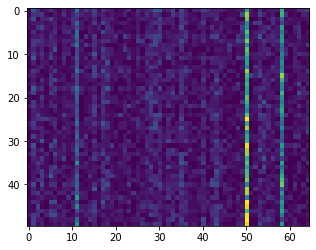

In [839]:
plt.imshow(X_grouped[:50])
#plt.plot(y_grouped)

In [840]:
# train glm to get contributions of each unit
data = np.column_stack([y_grouped, X_grouped])
columns = ['state'] + ["x%d" % x for x in range(X_grouped.shape[1])]
AM_df = pd.DataFrame(data, columns=columns)

model = glm('state ~ ' + ' + '.join(columns[1:]), data=AM_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  state   No. Observations:                  343
Model:                            GLM   Df Residuals:                      277
Model Family:                Gaussian   Df Model:                           65
Link Function:               identity   Scale:                         0.12597
Method:                          IRLS   Log-Likelihood:                -94.740
Date:                Tue, 17 Oct 2023   Deviance:                       34.893
Time:                        17:59:34   Pearson chi2:                     34.9
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8205
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8101      0.112     16.222      0.000       1.591       2.029
x0             0.4245      0.244      1.742      0.081      -0.053       0.902
x1            -0.3366      0.112     -3.005      0.003      -0.556      -0.117
x2            -0.0552      0.145     -0.381      0.703      -0.339       0.229
x3            -0.3395      0.136     -2.505      0.012      -0.605      -0.074
x4            -0.0553      0.202     -0.274      0.784      -0.451       0.340
x5            -0.1821      0.122     -1.495      0.135      -0.421       0.057
x6            -0.1961      0.132     -1.489      0.136      -0.454       0.062
x7            -0.1327      0.197     -0.675      0.500      -0.518       0.253
x8            -0.0750      0.143     -0.525      0.600      -0.355       0.205
x9            -0.2052      0.145     -1.411      0.158      -0.490       0.080
x10           -0.5321      0.168     -3.172      0.002      -0.861      -0.203
x11           -0.2208      0.082     -2.699      0.007      -0.381      -0.060
x12            0.0171      0.135      0.126      0.900      -0.248       0.283
x13           -0.1129      0.176     -0.643      0.520      -0.457       0.231
x14           -0.1382      0.170     -0.811      0.417      -0.472       0.196
x15           -0.4071      0.130     -3.141      0.002      -0.661      -0.153
x16            0.1253      0.174      0.719      0.472      -0.216       0.466
x17           -0.0866      0.096     -0.902      0.367      -0.275       0.102
x18           -0.1203      0.125     -0.959      0.337      -0.366       0.125
x19            0.2525      0.164      1.535      0.125      -0.070       0.575
x20           -0.5063      0.217     -2.332      0.020      -0.932      -0.081
x21            0.2507      0.166      1.509      0.131      -0.075       0.576
x22           -0.0450      0.155     -0.290      0.772      -0.349       0.259
x23           -0.3405      0.173     -1.967      0.049      -0.680      -0.001
x24           -0.1545      0.235     -0.658      0.511      -0.615       0.306
x25            0.0962      0.140      0.689      0.491      -0.177       0.370
x26            0.0556      0.176      0.317      0.752      -0.289       0.400
x27           -0.4976      0.142     -3.501      0.000      -0.776      -0.219
x28           -0.3468      0.128     -2.706      0.007      -0.598      -0.096
x29           -0.4084      0.129     -3.167      0.002      -0.661      -0.156
x30           -0.1672      0.120     -1.393      0.164      -0.403       0.068
x31            0.1145      0.202      0.566      0.571      -0.282       0.511
x32            0.0971      0.130      0.747      0.455      -0.158       0.352
x33           -0.0812      0.150     -0.540      0.589      -0.376       0.213
x34           -0.1402      0.171     -0.818      0.413      -0.476       0.196
x3

In [634]:
# significant units and pvalues
sign_unit_idxs = [i for i, pval in enumerate(model.pvalues[1:]) if pval < 0.05]
[(unit, model.pvalues[i]) for i, unit in enumerate(sel_units) if i in sign_unit_idxs]

[('1-14', 0.09925939654667804),
 ('1-15', 0.0066333163164266525),
 ('1-19', 0.7445549970736053),
 ('1-21', 0.22602096764005608),
 ('1-30', 0.16821075220576664),
 ('1-5', 0.19036168037760826),
 ('1-8', 0.24611992493154178)]

In [635]:
# PART 2 - test

# Try how much single population response with GLM coeffs can predict AEP_target value
# try bootstrapping by splitting train / test randomly 1000 times

glm_coeffs = dict([(i, coef) for i, coef in enumerate(model.params[1:]) if model.pvalues[1:][i] < 0.95])
#if len(glm_coeffs) == 0:
#    return 0, 0, model.params, model.pvalues
AEP_target_fit = np.zeros(len(y_test))
for idx, coef in glm_coeffs.items():
    AEP_target_fit += coef * X_test[:, idx]

corr, pval = stats.pearsonr(AEP_target_fit, y_test)
corr, pval

(0.1674229026734218, 1.1872138798050364e-12)

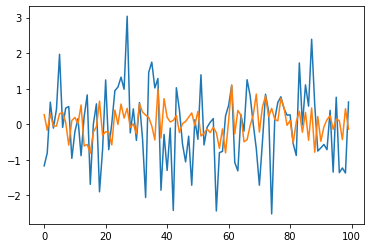

In [636]:
idx_l, idx_r = 0, 100
plt.plot(stats.zscore(AEP_target_fit)[idx_l:idx_r])
plt.plot(y_test[idx_l:idx_r])